In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set() # Setting seaborn as default style even if use only matplotlib

df_all = pd.concat(
    [
        pd.read_csv(
            f"https://raw.githubusercontent.com/ClassicSours/TheInterstellarAsteroidRush/main/Asteroids/Asteroid%20{i}.csv"
        )
        for i in range(1, 21)
    ]
)

In [ ]:
df_buzz = df_all[df_all['DRILL_BIT_NAME'] == 'Buzz Drilldrin']
df_astro = df_all[df_all['DRILL_BIT_NAME'] == 'AstroBit']
df_apollo = df_all[df_all['DRILL_BIT_NAME'] == 'Apollo']
df_challenge = df_all[df_all['DRILL_BIT_NAME'] == 'ChallengDriller']

In [ ]:
dfs = [df_buzz, df_astro, df_apollo, df_challenge]
for df in dfs:
  df= df.loc[~df.index.duplicated(), :]

In [ ]:
cat = {'DRILL_BIT_ID', 'DRILL_BIT_NAME'}
const = 15.0
# normalize
without_cats = []
for df in dfs:
  normalized_df = df
  normalized_df = normalized_df.loc[~normalized_df.index.duplicated(), :]
  for col in df.columns:
      if col not in cat:
          normalized_df[col] = (normalized_df[col]-normalized_df[col].mean())/normalized_df[col].std()
          Q1 = normalized_df[col].quantile(0.25)
          Q3 = normalized_df[col].quantile(0.75)
          IQR = (Q3 - Q1)    #IQR is interquartile range. 

          filter = (normalized_df[col] >= Q1 - 1.5 * IQR) & (normalized_df[col] <= Q3 + 1.5 *IQR)
          normalized_df = normalized_df[normalized_df[col] >= Q1 - const * IQR]
          normalized_df = normalized_df[normalized_df[col] <= Q3 + const * IQR]
          normalized_df = normalized_df[normalized_df[col] != 0]
  without_cats.append(normalized_df.drop(['DRILL_BIT_NAME'], axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
without_cats[0].head()

,BIT_DEPTH,RATE_OF_PENETRATION,HOOK_LOAD,DIFFERENTIAL_PRESSURE,WEIGHT_ON_BIT,DRILL_BIT_ID
0,-1.650501,0.201176,-1.633779,-2.060151,-2.536055,1
1,-1.650255,0.297355,-1.178382,-1.858231,-3.197556,1
2,-1.650176,0.297355,-1.258850,-1.907982,-3.028645,1
3,-1.649931,0.269115,-1.216966,-1.834140,-3.140975,1
4,-1.649853,0.340738,-1.233466,-1.927163,-3.175090,1


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import sklearn
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from joblib import dump, load

In [ ]:
from sklearn.preprocessing import MinMaxScaler

timestamps = 20

X_trains = []
Y_trains = []
X_tests = []
Y_tests = []

for without_cat in without_cats:
  training_set, testing_set = sklearn.model_selection.train_test_split(without_cat, test_size=0.2, random_state=25)
  sc = MinMaxScaler(feature_range=(0,1))
  training_set_scaled = sc.fit_transform(training_set.iloc[:, 2:5].values)
  testing_set_scaled = sc.fit_transform(testing_set.iloc[:, 2:5].values)
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []
  for i in range(timestamps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-timestamps:i, :])
    Y_train.append(training_set_scaled[i, 1])
  for i in range(timestamps, len(testing_set_scaled)):
    X_test.append(testing_set_scaled[i-timestamps:i, :])
    Y_test.append(testing_set_scaled[i, 1])  
  X_train, Y_train = np.array(X_train), np.array(Y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))
  X_trains.append(X_train)
  Y_trains.append(Y_train)
  X_test, Y_test = np.array(X_test), np.array(Y_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))
  X_tests.append(X_test)
  Y_tests.append(Y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense 

In [ ]:
models = []

for i in range(len(without_cats)):
  model = Sequential()

  model.add(LSTM(units=50,return_sequences=True,input_shape=(timestamps, 3)))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50,return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50,return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50))
  model.add(Dropout(0.2))

  model.add(Dense(units=1))

  model.compile(optimizer='adam',loss='mean_squared_error')

  model.fit(X_trains[i],Y_trains[i],epochs=20,batch_size=32)

  models.append(model)

Epoch 1/20
455/455 [==============================] - 50s 10ms/step - loss: 0.0201
Epoch 2/20
455/455 [==============================] - 4s 10ms/step - loss: 0.0133
Epoch 3/20
455/455 [==============================] - 4s 10ms/step - loss: 0.0125
Epoch 4/20
455/455 [==============================] - 4s 10ms/step - loss: 0.0121
Epoch 5/20
455/455 [==============================] - 4s 10ms/step - loss: 0.0117
Epoch 6/20
455/455 [==============================] - 4s 10ms/step - loss: 0.0114
Epoch 7/20
455/455 [==============================] - 4s 10ms/step - loss: 0.0112
Epoch 8/20
455/455 [==============================] - 4s 10ms/step - loss: 0.0109
Epoch 9/20
455/455 [==============================] - 5s 11ms/step - loss: 0.0108
Epoch 10/20
455/455 [==============================] - 4s 10ms/step - loss: 0.0105
Epoch 11/20
455/455 [==============================] - 4s 10ms/step - loss: 0.0104
Epoch 12/20
455/455 [==============================] - 4s 9ms/step - loss: 0.0104
Epoch 13/20
4

In [ ]:
for i in range(4):
  models[i].save('model' + str(i))

In [ ]:
!zip -r /content/model4.zip /content/model3

  adding: content/model3/ (stored 0%)
  adding: content/model3/variables/ (stored 0%)
  adding: content/model3/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model3/variables/variables.index (deflated 69%)
  adding: content/model3/assets/ (stored 0%)
  adding: content/model3/saved_model.pb (deflated 91%)
  adding: content/model3/keras_metadata.pb (deflated 93%)


In [ ]:
predicted = models[0].predict(X_tests[0])
print(predicted)

114/114 [==============================] - 1s 6ms/step
[[0.73961896]
 [0.7396183 ]
 [0.73961216]
 ...
 [0.73957413]
 [0.7395885 ]
 [0.7396027 ]]


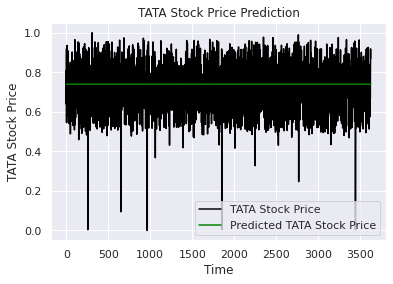

In [ ]:

plt.plot(Y_tests[0], color = 'black', label = 'TATA Stock Price')
plt.plot(predicted, color = 'green', label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()